# Creación de conversaciones DNS

### Descripción: 
Con este código se va a intentar crear todos los pasos de una conversación DNS, mediante IA generativa. Se pretende pasar una descripción de esta conversación al modelo y que este sea capaz de crear todos los pasos/paquetes necesarios para replicar una conversación con esas mismas especificaciones

In [ ]:
import random
import re
import pickle
import time

import openai
openai.api_key = "FILL"

from scapy.all import *
from scapy.utils import RawPcapReader, wrpcap
import scapy.all as scapy

from scapy.layers.inet import IP
from scapy.all import DNS


openai.__version__

C:\Users\adayd\anaconda3\envs\PAC-GPT\Lib\site-packages\scapy\layers\ipsec.py:469: CryptographyDeprecationWarning: Blowfish has been deprecated
  cipher=algorithms.Blowfish,
C:\Users\adayd\anaconda3\envs\PAC-GPT\Lib\site-packages\scapy\layers\ipsec.py:483: CryptographyDeprecationWarning: CAST5 has been deprecated
  cipher=algorithms.CAST5,


'1.10.0'

## Generación de la descipción de una comunicación DNS

<center><img src="https://unit42.paloaltonetworks.com/wp-content/uploads/2020/03/Figure-1.-Simplified-DNS-operation.jpg">
    
<center> Esta imagen es genérica y simple, en la que el receptor del paquete tiene la información que se solicita y esta es úicamente la IP de una web.
<br>
    ---
<br>Una conversación normal DNS puede ser de diferentes tipos, e involucrar a muchos tipos de equipos diferentes, por simplicidad, como primera aproximación para este tipo de conversaciones, se generarán comunicaciones entre 2 equipos predefinidos en las que solo se solicite una IP. Esto se hace para evaluar la viabilidad de estos modelos de IA generativa para generar conversaciones realistas (aunque simples) DNS.
<center>---

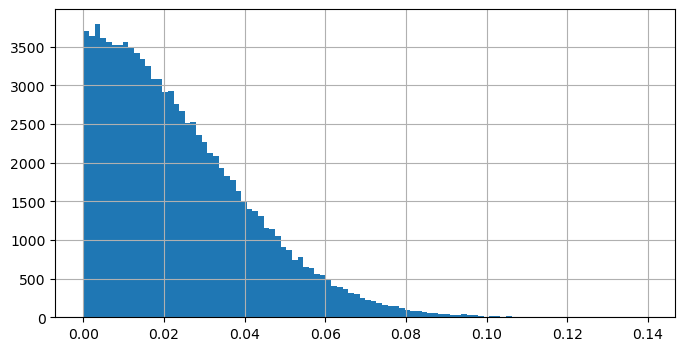

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 4))
plt.hist([abs(random.gauss(0, 0.03)) for i in range(100000)], bins = 100)
plt.grid()
plt.show()

In [3]:
query = "This is a DNS conversation summary:\n"
query += 'Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"\n'
query += "This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:\n"
query += "RANDOM_PORT = random.randint(4097, 65530)\n"
query += 'pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )\n'
query += 'time.sleep(abs(random.gauss(0, 0.03)))'
query += 'pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN"), an=DNSRR(rrname="www.github.com", type="A", rclass="IN", ttl=255, rdata="140.82.112.4") )\n'

## Carga de posibles conversaciones

In [4]:
with open("../../data/Conversations/DNS/DNS_Conv_Testing2.txt","r",encoding="utf8") as f:
    Conv_summaries = f.read().splitlines()

print("Número de resúmenes: " +str(len(Conv_summaries)))

Número de resúmenes: 220


In [5]:
test_group = random.choices(Conv_summaries,k=200)

### Carga de posibles respuestas anteriores para encadenarlas

In [6]:
class response():
    "Stores name and place pairs"
    def __init__(self, name, place):
        self.prompt_summary = name
        self.completion = place

In [7]:
try:
    responses = pickle.load( open("../../data/Conversations/DNS/pickle/DNS_validation_pairs_Aday_v3.pkl", "rb" ))
except:
    responses = []
    
print("Number of previous responses: " + str(len(responses)))

Number of previous responses: 0


## Generación de comandos de paquetes de conversación

In [8]:
index = 0

In [9]:

for i in range(len(test_group)):
   
    summary = Conv_summaries[i]
    
    query1=query    
    print("...........................................")
    print( " GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter " +str(i+1) +")")
    

    ## Luego seleccionas aleatoriamente resumenes ya generados para pedirle que te saque el comando a partir del paquete
    #summaries = random.choices(Conv_summary,k=summaries_per_request)
    text_sum = ""
    
    query1 += "This is a conversation summary:\n"
    query1 += summary + "\n"
    text_sum += summary + "\n"
    query1 += "\nGenerate python code for creating the packets in the conversation with scapy framework.Don´t give back any comments, just bare code.\n"
    query1 += "Use the following structure:\n"
    query1 += "RANDOM_PORT =...\n"
    query1 += "pkt_1=...\n"
    query1 += "time.sleep(abs(random.gauss(0, 0.03)))\n"
    query1 += "pkt_2=...\n"
    
    #Query es el mensaje que le envias al modelo
    print(query1)

    #Esta es la petición que le mandas al modelo de IA
    completion = openai.completions.create(
        model="gpt-3.5-turbo-instruct", 
        prompt=query1,
        max_tokens=2600,
        temperature=0.1)

    
    print("...Generated!")
    
    # Guardamos tanto el resumen de los paquetes que solicitamos y lo que devuelve el modelo para estos paquetes
    responses.append(response(text_sum, completion))
    
    # Guardamos tanto la petición como la respuesta en un archivo
    pickle.dump(responses, open( "../../data/Conversations/DNS/pickle/DNS_validation_pairs_Aday_v3.pkl", "wb" ) )
    
    exec(responses[-1].completion.choices[0].text)
    
    with open("../../data/Conversations/DNS/pcap/DNS_v3_generated_3_5_turbo-instruct_conv_v3.pcap", "ba+") as f:
        wrpcap(f, pkt_1, append=True)
    
    with open("../../data/Conversations/DNS/pcap/DNS_v3_generated_3_5_turbo-instruct_conv_v3.pcap", "ba+") as f:
        wrpcap(f, pkt_2, append=True)
    
    print("Number of completitions done: " + str(len(responses)))

...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 1)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN"), an=DNSRR(rrname="www.github.com", t

...Generated!
Number of completitions done: 6
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 7)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qcl

...Generated!
Number of completitions done: 12
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 13)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 18
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 19)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 24
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 25)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 30
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 31)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 36
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 37)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 42
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 43)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 48
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 49)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 54
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 55)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 60
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 61)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 66
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 67)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 72
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 73)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 78
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 79)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 84
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 85)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 90
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 91)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 96
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 97)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", q

...Generated!
Number of completitions done: 102
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 103)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 108
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 109)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 114
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 115)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 120
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 121)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 126
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 127)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 132
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 133)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 138
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 139)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 144
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 145)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 150
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 151)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 156
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 157)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 162
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 163)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 168
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 169)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 174
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 175)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 180
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 181)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 186
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 187)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 192
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 193)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

...Generated!
Number of completitions done: 198
...........................................
 GENERATING SCAPY COMMANDS FOR THE FOLLOWING CONVERSATIONS (iter 199)
This is a DNS conversation summary:
Source: IP="192.168.1.10" // Destination: IP="192.168.1.20"// Others: id=0x0045 , resource= "www.github.com" , response = "140.82.112.4"
This is the python code to generate a random port number and the request and reply packets of the conversation, respectively:
RANDOM_PORT = random.randint(4097, 65530)
pkt_1= IP(src="192.168.1.10", dst="192.168.1.20", proto=17)/UDP(sport=RANDOM_PORT, dport=53)/DNS(id=0x0045, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A", qclass="IN") )
time.sleep(abs(random.gauss(0, 0.03)))pkt_2= IP(src="192.168.1.20", dst="192.168.1.10", proto=17)/UDP(sport=53, dport=RANDOM_PORT)/DNS(id=0x0aba, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.github.com", qtype="A",

In [48]:
# Este es el resumen de lo que está en el struct de responses para la última petición
print(responses[-1].prompt_summary)
print(responses[-1].completion.choices[0].text)

Source: IP="192.168.1.254" // Destination: IP="192.168.1.253" // Others: id=0x2384 , resource= www.amazon.com , response = "176.32.103.205"


pkt_list = []

# Request packet
pkt_list.append(IP(src="192.168.1.254", dst="192.168.1.253", proto=17)/UDP(sport=12345, dport=53)/DNS(id=0x2384, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.amazon.com", qtype="A", qclass="IN")))

# Response packet
pkt_list.append(IP(src="176.32.103.205", dst="192.168.1.254", proto=17)/UDP(sport=53, dport=12345)/DNS(id=0x2384, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.amazon.com", qtype="A", qclass="IN"), an=DNSRR(rrname="www.amazon.com", type="A", rclass="IN", ttl=255, rdata="176.32.103.205"))


In [62]:
#Esta es la forma que tiene una respuesta del modelo de IA
print(responses[-1].completion)

Completion(id='cmpl-92FB5D7MemVeJpZlaomyjw2L6FG9x', choices=[CompletionChoice(finish_reason='stop', index=0, logprobs=None, text='\n\nimport scapy.all as scapy\n\n# Generate random MAC address for the responding end\nimport random\nmac = [random.randint(0x00, 0xff) for i in range(6)]\nmac[0] |= 0x02\nmac = ":".join(["%02x" % x for x in mac])\n\n# Create request packet\nrequest_pkt = scapy.Ether(src="f3:a4:b5:c6:d7:e8", dst="FF:FF:FF:FF:FF:FF")/scapy.ARP(op=1, pdst="172.16.3.20", psrc="172.16.3.10", hwdst="00:00:00:00:00:00", hwsrc="f3:a4:b5:c6:d7:e8")\n\n# Create reply packet\nreply_pkt = scapy.Ether(src=mac, dst="f3:a4:b5:c6:d7:e8")/scapy.ARP(op=2, psrc="172.16.3.20", hwsrc=mac, hwdst="f3:a4:b5:c6:d7:e8", pdst="172.16.3.10")\n\n# Add packets to list\npkt_list = [request_pkt, reply_pkt]')], created=1710322027, model='gpt-3.5-turbo-instruct', object='text_completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=274, prompt_tokens=455, total_tokens=729))


### Generación de paquetes

In [65]:
# Ejecutamos los comandos que devuelve el modelo para generar los paquetes
exec(responses[-1].completion.choices[0].text)
print(pkt_list)

[<Ether  dst=FF:FF:FF:FF:FF:FF src=f3:a4:b5:c6:d7:e8 type=ARP |<ARP  op=who-has hwsrc=f3:a4:b5:c6:d7:e8 psrc=172.16.3.10 hwdst=00:00:00:00:00:00 pdst=172.16.3.20 |>>, <Ether  dst=f3:a4:b5:c6:d7:e8 src=e7:44:42:a0:65:a0 type=ARP |<ARP  op=is-at hwsrc=e7:44:42:a0:65:a0 psrc=172.16.3.20 hwdst=f3:a4:b5:c6:d7:e8 pdst=172.16.3.10 |>>]


In [67]:
#Enviarlos para probar si se envian correctamente
send(pkt_list)


Sent 2 packets.


### Introducción en un pcap

In [50]:
pkt_list = []

# Request packet
pkt_list.append(IP(src="192.168.1.254", dst="192.168.1.253", proto=17)/UDP(sport=12345, dport=53)/DNS(id=0x2384, qr=0, rd=1, opcode=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=DNSQR(qname="www.amazon.com", qtype="A", qclass="IN")))

# Response packet
pkt_list.append(IP(src="176.32.103.205", dst="192.168.1.254", proto=17)/UDP(sport=53, dport=12345)/DNS(id=0x2384, qr=1, opcode=0, ra=1, rcode=0, qdcount=1, ancount=1, nscount=0, arcount=0, qd=DNSQR(qname="www.amazon.com", qtype="A", qclass="IN"), an=DNSRR(rrname="www.amazon.com", type="A", rclass="IN", ttl=255, rdata="176.32.103.205")))

In [54]:
# Guardamos los paquetes generados en un pcap
with open("../../data/Conversations/DNS/pcap/DNSgenerated_3_5_turbo-instruct_conv.pcap", "ba+") as f:
    wrpcap(f, pkt_list, append=True)